<a href="https://colab.research.google.com/github/nepridumalnik/Jupyter-Notebooks/blob/master/speech_recognizer/SpeechRecognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Интересные ссылки:
- [Конкурс](https://www.kaggle.com/competitions/tensorflow-speech-recognition-challenge);
- [Исследование данных](https://www.kaggle.com/code/davids1992/speech-representation-and-data-exploration);
- [Загрузка файлов](https://www.tensorflow.org/io/api_docs/python/tfio/audio/decode_wav);
- [Keras с ансамблем](https://www.kaggle.com/code/araspirbadian/voice-command-detection).


# Подготовка данных
## Загрузка архива с сэмплами

In [1]:
import requests
from tqdm import tqdm
import os

URL: str = "http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz"
OUT_FILE: str = "./speech_commands_v0.01.tar.gz"

def download_file(url: str, out_file: str) -> None:
  CHUNK_SIZE: int = 2 * 1024 * 1024

  if os.path.exists(out_file):
    print(f"File \"{out_file}\" exists")
    return

  with requests.get(url, stream=True) as request, open(out_file, "wb") as f:
    length = int(request.headers.get("content-length", 0))
    steps = length // CHUNK_SIZE + (1 if length % CHUNK_SIZE else 0)

    for chunk in tqdm(request.iter_content(chunk_size=CHUNK_SIZE),
                      total=steps, unit="chunk"):
      if chunk:
        f.write(chunk)


download_file(URL, OUT_FILE)


File "./speech_commands_v0.01.tar.gz" exists


## Распаковка

In [2]:
import tarfile

ARCHIVE_DIR: str = "inputs"

def extract_file(file_path: str, extract_path: str) -> None:
  if os.path.exists(extract_path) and os.listdir(extract_path):
    print(f"Directory \"{extract_path}\" exists")
    return

  with tarfile.open(file_path, "r:gz") as tar:
    members = tar.getmembers()
    with tqdm(total=len(members), unit="file") as pbar:
      for member in members:
        tar.extract(member, path=extract_path)
        pbar.update(1)

extract_file(OUT_FILE, ARCHIVE_DIR)


Directory "inputs" exists


## Получаем список лейблов

In [3]:
NOISE_LABEL: str = "_background_noise_"

LABELS = set([ name for name in os.listdir(ARCHIVE_DIR)
              if os.path.isdir(os.path.join(ARCHIVE_DIR, name)) ])
LABELS.remove(NOISE_LABEL)

LABELS


{'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'four',
 'go',
 'happy',
 'house',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'wow',
 'yes',
 'zero'}

# Изучение данных
## Загрузить WAV файл

In [4]:
import tensorflow as tf
import numpy as np

test_label = "bed"
file_path = str()
file_dir = os.path.join(ARCHIVE_DIR, test_label)

for e in os.listdir(os.path.join(ARCHIVE_DIR, test_label)):
  file_path = os.path.join(file_dir, e)
  break

file_data = tf.io.read_file(file_path)
samples, sample_rate = tf.audio.decode_wav(file_data)
samples = tf.squeeze(samples, axis=-1)

stfts = tf.signal.stft(samples,
                       frame_length=256,
                       frame_step=128)
spectrogram = tf.abs(stfts)


## Демонстрация аудио данных

Показана волона и спектрограмма

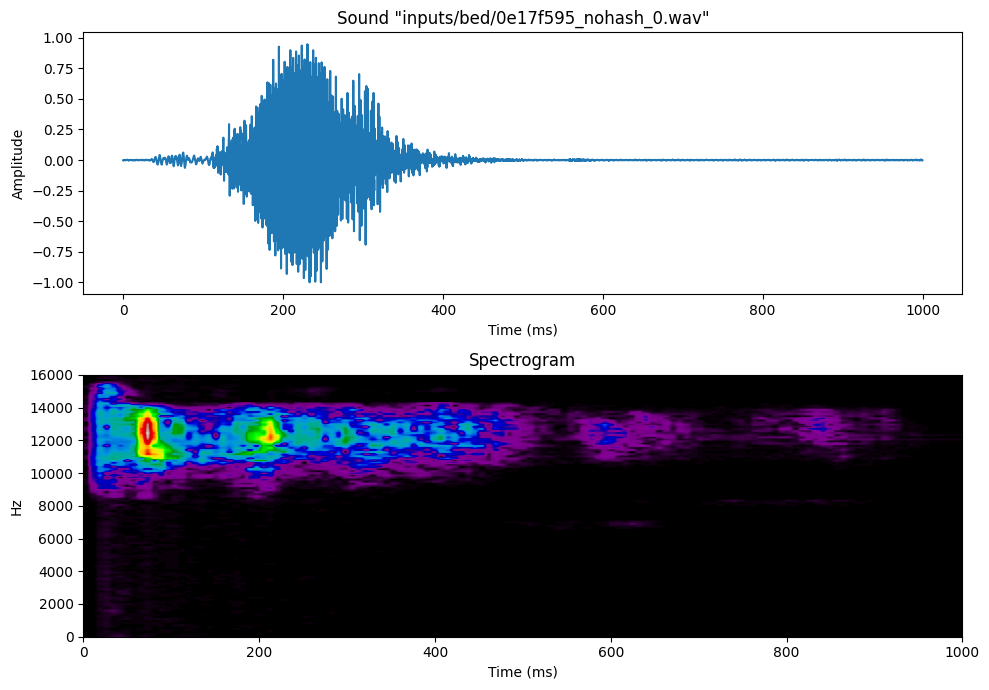

In [5]:
import matplotlib.pyplot as plt
import matplotlib.colorbar as cbar

plot = plt.figure(figsize=(10, 7))
subplot_1 = plot.add_subplot(211)

time_ms = np.arange(len(samples)) / sample_rate * 1000
subplot_1.plot(time_ms, samples)

subplot_1.set_title(f"Sound \"{file_path}\"")
subplot_1.set_ylabel("Amplitude")
subplot_1.set_xlabel("Time (ms)")

subplot_2 = plot.add_subplot(212)

spectrogram_plot = subplot_2.imshow(
    np.log1p(spectrogram),
    aspect="auto",
    cmap="nipy_spectral",
    extent=[0, 1000, 0, int(samples.shape[0])]
)

subplot_2.set_title("Spectrogram")
subplot_2.set_ylabel("Hz")
subplot_2.set_xlabel('Time (ms)')

plot.tight_layout()


## Получение мел-кепстральной спектрограммы (MFCC)
[Туториал TF](https://www.tensorflow.org/api_docs/python/tf/signal/mfccs_from_log_mel_spectrograms)

In [6]:
num_spectrogram_bins = stfts.shape[-1]
lower_edge_hertz = 80.0
upper_edge_hertz = 8000.0
num_mel_bins = 80

linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins,
    num_spectrogram_bins,
    sample_rate,
    lower_edge_hertz,
    upper_edge_hertz
)

mel_power_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
mel_power_spectrogram.set_shape(
    spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:])
)

# Добавляем небольшой эпсилон для смягчения нулевых и околонулевых значений логарифма
mel_power_spectrogram = tf.math.log(mel_power_spectrogram + 1e-6)


## Визуализация шкалы мел

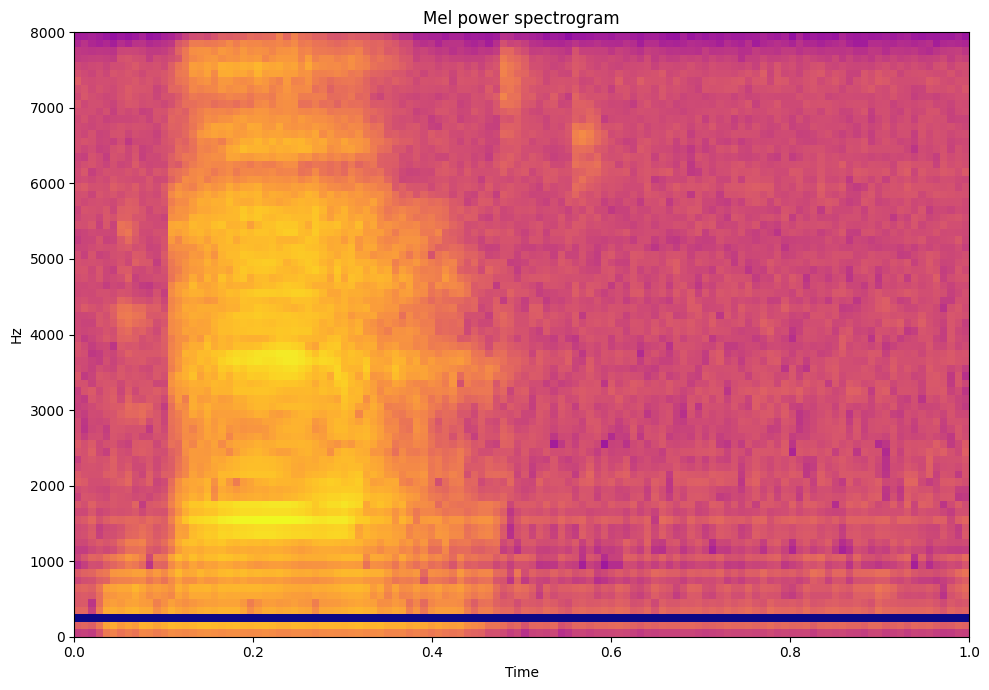

In [7]:
plot = plt.figure(figsize=(10, 7))
mel_subplot = plot.add_subplot(111)
mel_subplot.imshow(
    mel_power_spectrogram.numpy().T,
    aspect="auto",
    origin="lower",
    cmap="plasma",
    extent=[0, 1, 0, upper_edge_hertz]
)

mel_subplot.set_title("Mel power spectrogram")
mel_subplot.set_ylabel("Hz")
mel_subplot.set_xlabel("Time")

plot.tight_layout()


## Визуализация мел-кепстральной спектрограммы

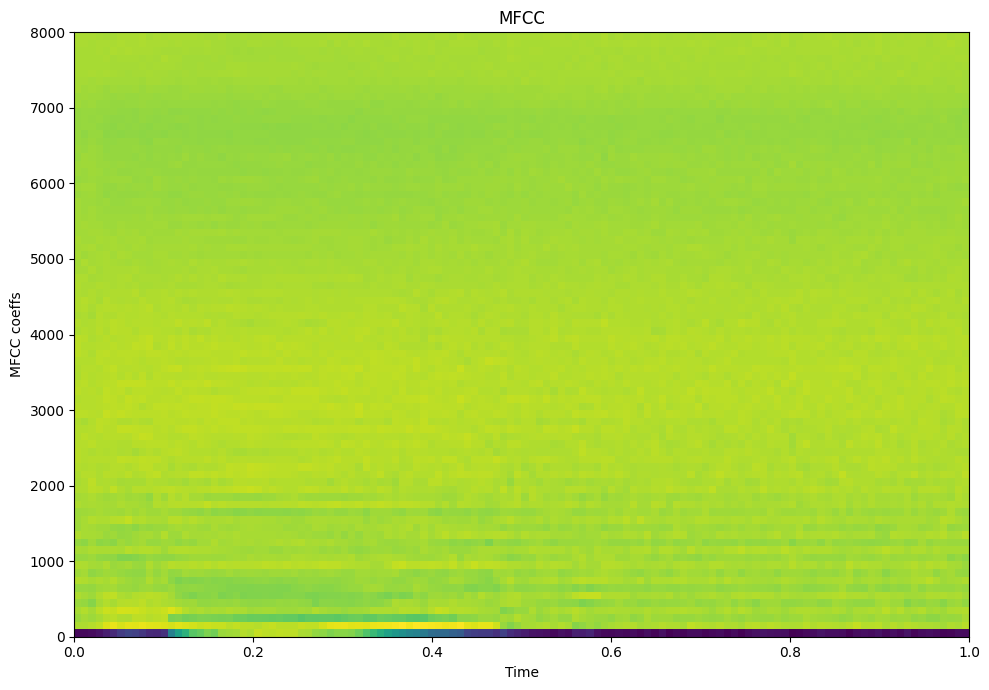

In [8]:
mfcc_spectrogram = tf.signal.mfccs_from_log_mel_spectrograms(mel_power_spectrogram)

plot = plt.figure(figsize=(10, 7))
mfcc_subplot = plot.add_subplot(111)
mfcc_subplot.imshow(
    mfcc_spectrogram.numpy().T,
    aspect="auto",
    origin="lower",
    cmap="viridis",
    extent=[0, 1, 0, upper_edge_hertz]
)

mfcc_subplot.set_title("MFCC")
mfcc_subplot.set_ylabel("MFCC coeffs")
mfcc_subplot.set_xlabel("Time")

plot.tight_layout()


## Визуализация спектрограммы в 3D

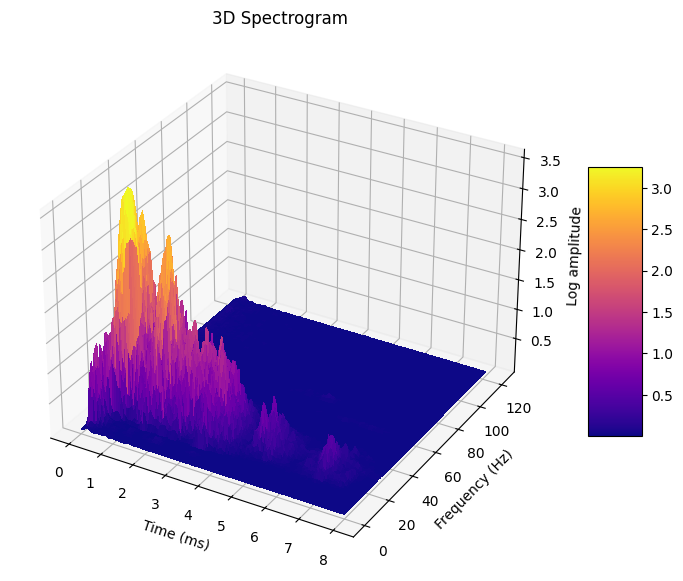

In [9]:
time_axis = np.arange(spectrogram.shape[1]) / sample_rate * 1000
freqs_axis = np.arange(spectrogram.shape[0])

plot = plt.figure(figsize=(10, 7))

subplot_3d = plot.add_subplot(111, projection='3d')
time, freq = np.meshgrid(time_axis, freqs_axis)

surf = subplot_3d.plot_surface(time, freq, np.log1p(spectrogram),
                            cmap="plasma", rstride=1, cstride=1,
                            linewidth=0, antialiased=False)

plot.colorbar(surf, ax=subplot_3d, shrink=0.5, aspect=5)

subplot_3d.set_title("3D Spectrogram")
subplot_3d.set_xlabel("Time (ms)")
subplot_3d.set_ylabel("Frequency (Hz)")
_ = subplot_3d.set_zlabel("Log amplitude")


# Подготовка набора данных
## Загрузка шумов

In [10]:
import pandas as pd

def load_file(name: str):
  audio_binary = tf.io.read_file(file_path)
  audio, _ = tf.audio.decode_wav(audio_binary)
  return audio_binary.numpy()

def load_dir_as_dataset(path: str, label: str) -> pd.DataFrame:
  files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith(".wav")]

  df = pd.DataFrame(
      {
          "label": label,
          "data": files
      }
  )

  df["audio"] = df["data"].map(load_file)

  return df

noise_dir = os.path.join(ARCHIVE_DIR, NOISE_LABEL)
noise_df = load_dir_as_dataset(noise_dir, NOISE_LABEL)

print(noise_df.head())


                label                                            data  \
0  _background_noise_       inputs/_background_noise_/white_noise.wav   
1  _background_noise_     inputs/_background_noise_/exercise_bike.wav   
2  _background_noise_        inputs/_background_noise_/pink_noise.wav   
3  _background_noise_     inputs/_background_noise_/dude_miaowing.wav   
4  _background_noise_  inputs/_background_noise_/doing_the_dishes.wav   

                                               audio  
0  b'RIFF$}\x00\x00WAVEfmt \x10\x00\x00\x00\x01\x...  
1  b'RIFF$}\x00\x00WAVEfmt \x10\x00\x00\x00\x01\x...  
2  b'RIFF$}\x00\x00WAVEfmt \x10\x00\x00\x00\x01\x...  
3  b'RIFF$}\x00\x00WAVEfmt \x10\x00\x00\x00\x01\x...  
4  b'RIFF$}\x00\x00WAVEfmt \x10\x00\x00\x00\x01\x...  


## Загрузка всех данных

In [11]:
all_dfs = []

for label in LABELS:
  print(f"Loading \"{label}\" dataframe")
  df = load_dir_as_dataset(os.path.join(ARCHIVE_DIR, label), label)
  all_dfs.append(df)

df = pd.concat(all_dfs, ignore_index=True)

print("Done!")


Loading "off" dataframe
Loading "nine" dataframe
Loading "wow" dataframe
Loading "marvin" dataframe
Loading "four" dataframe
Loading "dog" dataframe
Loading "three" dataframe
Loading "two" dataframe
Loading "bed" dataframe
Loading "seven" dataframe
Loading "tree" dataframe
Loading "on" dataframe
Loading "one" dataframe
Loading "eight" dataframe
Loading "go" dataframe
Loading "yes" dataframe
Loading "happy" dataframe
Loading "bird" dataframe
Loading "sheila" dataframe
Loading "down" dataframe
Loading "up" dataframe
Loading "zero" dataframe
Loading "no" dataframe
Loading "left" dataframe
Loading "house" dataframe
Loading "five" dataframe
Loading "stop" dataframe
Loading "right" dataframe
Loading "cat" dataframe
Loading "six" dataframe
Done!


In [14]:
df.head()


,label,data,audio
0,off,inputs/off/0e17f595_nohash_0.wav,b'RIFF$}\x00\x00WAVEfmt \x10\x00\x00\x00\x01\x...
1,off,inputs/off/85b877b5_nohash_2.wav,b'RIFF$}\x00\x00WAVEfmt \x10\x00\x00\x00\x01\x...
2,off,inputs/off/a827e3a1_nohash_3.wav,b'RIFF$}\x00\x00WAVEfmt \x10\x00\x00\x00\x01\x...
3,off,inputs/off/f953e1af_nohash_3.wav,b'RIFF$}\x00\x00WAVEfmt \x10\x00\x00\x00\x01\x...
4,off,inputs/off/82c6d220_nohash_3.wav,b'RIFF$}\x00\x00WAVEfmt \x10\x00\x00\x00\x01\x...


## Построение модели НН

In [15]:
import keras as k
